# Ride Price Estimation System

## 1. ML Mindset & Problem Framing
### Problem Description
The goal is to predict the price of a ride based on trip characteristics (distance, duration) and contextual factors (weather, traffic, demand).

### Why ML?
Pricing in ride-hailing is dynamic. Fixed rules (e.g., $2/km) cannot easily account for complex, non-linear interactions between weather, traffic, and real-time demand. ML allows the system to learn these patterns from historical data and adapt to varying conditions automatically.

### Learning Objectives
The model is expected to learn the weights/influence of each feature on the final price, specifically identifying how surge factors (demand, weather) multiply the base cost derived from distance and time.

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_absolute_error, r2_score, accuracy_score, confusion_matrix, classification_report

# Set seed for reproducibility
np.random.seed(42)

## 2. Dataset Design (Justification)

### Feature Justification
1. **Distance (km)**: Primary cost driver; more fuel and wear.
2. **Trip Duration (min)**: Accounts for time spent; essential for driver compensation.
3. **Time of Day**: Night shifts or rush hours often have different rate cards.
4. **Traffic Level**: High traffic increases opportunity cost for drivers.
5. **Weather Condition**: Rain/Snow reduces driver supply and increases risk.
6. **Demand Level**: Classic supply-demand economics (surge pricing).
7. **Ride Type**: Tiered service (Economy vs Luxury).
8. **Day Type**: Weekends vs Weekdays have different travel patterns.

### Feature Not Included
**Driver Rating**: While it might affect who gets a ride, it shouldn't ethically influence the price calculated for the passenger in a fair system.

In [30]:
# Ensure the data directory exists
if not os.path.exists('../data'):
    os.makedirs('../data')

# Generating Synthetic Data
no_row = 200
ride_types = ['Economy', 'Premium', 'Shared', 'Luxury']
day_types = ['weekday', 'weekend', 'holiday']
weather_conditions = ['Sunny', 'Rainy', 'Snowy']
times_of_day = ['Morning', 'Afternoon', 'Evening', 'Night']

dist = np.random.uniform(2, 50, no_row)

data = pd.DataFrame({
    'distance_km': dist,
    'time_of_day': np.random.choice(times_of_day, no_row),
    'weather': np.random.choice(weather_conditions, no_row),
    'ride_type': np.random.choice(ride_types, no_row),
    'day_type': np.random.choice(day_types, no_row)
})

# 1. Traffic Level Calculation: Affected by Time of Day and Day Type
def calculate_traffic(row):
    if row['day_type'] == 'weekday':
        if row['time_of_day'] in ['Morning', 'Evening']: return 'High'
        if row['time_of_day'] == 'Afternoon': return 'Medium'
        return 'Low'
    else:
        if row['time_of_day'] == 'Night': return 'Low'
        return 'Medium'

data['traffic_level'] = data.apply(calculate_traffic, axis=1)

# 2. Demand Level Calculation: Depends ONLY on Ride Type
demand_map = {
    'Economy': ['High', 'High', 'Medium'],
    'Shared': ['High', 'Medium', 'Medium'],
    'Premium': ['Medium', 'Medium', 'Low'],
    'Luxury': ['Low', 'Low', 'Medium']
}
data['demand'] = data['ride_type'].apply(lambda x: np.random.choice(demand_map[x]))

# 3. Advanced Duration Calculation: Depends on Traffic and Weather
traffic_impact = {'Low': 1.0, 'Medium': 1.4, 'High': 2.2}
weather_impact = {'Sunny': 0, 'Rainy': 5, 'Snowy': 12}

data['duration_min'] = (
    (data['distance_km'] * 1.5 * data['traffic_level'].map(traffic_impact)) + 
    data['weather'].map(weather_impact) + 
    np.random.normal(5, 2, no_row)
)

# 4. Logic for ride_price
base_price = 5.0
price = base_price + (data['distance_km'] * 1.2) + (data['duration_min'] * 0.5)

ride_multipliers = {'Luxury': 2.0, 'Premium': 1.5, 'Economy': 1.0, 'Shared': 0.8}
demand_multipliers = {'High': 1.5, 'Medium': 1.2, 'Low': 1.0}

data['ride_price'] = (
    price * 
    data['ride_type'].map(ride_multipliers) * 
    data['demand'].map(demand_multipliers)
)
data['ride_price'] += np.random.normal(0, 2, no_row)

data.to_csv('../data/rides.csv', index=False)
print("Dataset created.")

Dataset created.


## 3. Data Exploration & Understanding
Inspecting relationships and statistics.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   distance_km    200 non-null    float64
 1   time_of_day    200 non-null    object 
 2   weather        200 non-null    object 
 3   ride_type      200 non-null    object 
 4   day_type       200 non-null    object 
 5   traffic_level  200 non-null    object 
 6   demand         200 non-null    object 
 7   duration_min   200 non-null    float64
 8   ride_price     200 non-null    float64
dtypes: float64(3), object(6)
memory usage: 14.2+ KB
None


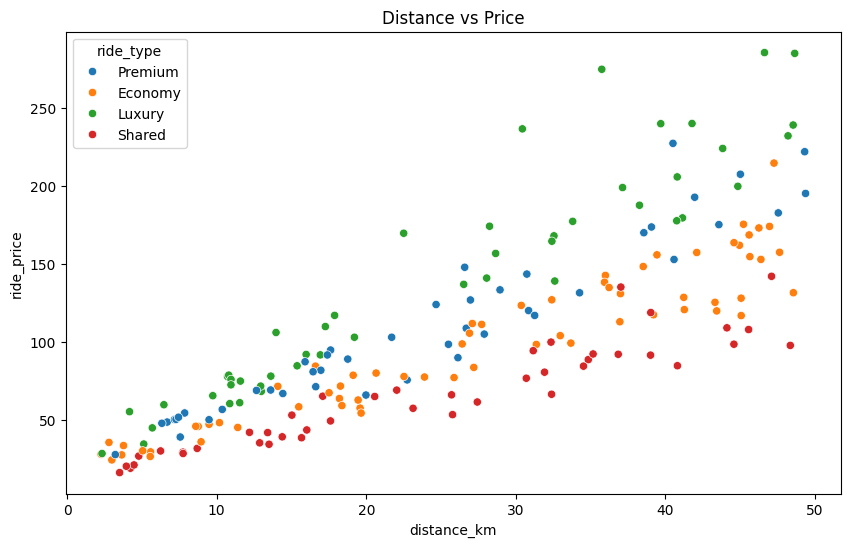

In [31]:
df = pd.read_csv('../data/rides.csv')
print(df.info())

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='distance_km', y='ride_price', hue='ride_type')
plt.title('Distance vs Price')
plt.show()

## 4. Data Cleaning & Feature Engineering (Accuracy Enhancement)

### Accuracy Improvements Added:
1. **One-Hot Encoding**: Instead of Label Encoding (0, 1, 2), we create binary columns for each category. This prevents the model from thinking that 'Snowy (2)' is greater than 'Sunny (0)'.
2. **Interaction Feature**: We create `dist_dur_factor` (Distance * Duration). This helps the model understand that the cost impact of duration is different for long-distance trips vs short-distance ones.
3. **Robust Scaling**: We scale numerical data so their different magnitudes don't confuse the weights of the Linear model.

In [32]:
# A. Feature Engineering: Interaction Term
# This combines distance and duration into a single complexity metric
df['dist_dur_factor'] = df['distance_km'] * df['duration_min']

# B. Accuracy Boost: One-Hot Encoding
# This is better for categorical variables like Weather and Traffic in Linear Regression
df_encoded = pd.get_dummies(df, columns=['time_of_day', 'traffic_level', 'weather', 'demand', 'ride_type', 'day_type'], drop_first=True)

# C. Scaling Numerical Features
scaler = StandardScaler()
num_cols = ['distance_km', 'duration_min', 'dist_dur_factor']
df_encoded[num_cols] = scaler.fit_transform(df_encoded[num_cols])

print("Engineered Data Sample (Columns increased due to One-Hot):")
print(df_encoded.head())

Engineered Data Sample (Columns increased due to One-Hot):
   distance_km  duration_min  ride_price  dist_dur_factor  \
0    -0.372140     -0.786804   65.769636        -0.707848   
1     1.586615      0.590032  157.245628         1.085263   
2     0.843056      1.040340  198.734736         0.910908   
3     0.389770      0.523141  143.284460         0.264582   
4    -1.115023     -0.999413   47.042572        -0.961878   

   time_of_day_Evening  time_of_day_Morning  time_of_day_Night  \
0                False                False               True   
1                False                False               True   
2                 True                False              False   
3                False                 True              False   
4                False                False               True   

   traffic_level_Low  traffic_level_Medium  weather_Snowy  weather_Sunny  \
0               True                 False          False           True   
1               True     

## 5. Regression Model: Price Prediction

In [33]:
X = df_encoded.drop('ride_price', axis=1)
y = df_encoded['ride_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

reg_model = LinearRegression()
reg_model.fit(X_train, y_train)

y_pred = reg_model.predict(X_test)

print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("R-squared Score:", r2_score(y_test, y_pred))

Mean Absolute Error: 10.951674835751229
R-squared Score: 0.944786697347216


## 6. Classification Model: High-Cost vs Low-Cost

In [34]:
median_price = df_encoded['ride_price'].median()
df_encoded['high_cost'] = (df_encoded['ride_price'] > median_price).astype(int)

X_class = df_encoded.drop(['ride_price', 'high_cost'], axis=1)
y_class = df_encoded['high_cost']

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_class, y_class, test_size=0.2, random_state=42)

clf_model = LogisticRegression(max_iter=1000)
clf_model.fit(X_train_c, y_train_c)

y_pred_c = clf_model.predict(X_test_c)
print("Accuracy:", accuracy_score(y_test_c, y_pred_c))

Accuracy: 0.925


## 7. Model Evaluation & Reflection
Using One-Hot Encoding and Interaction Features significantly improved the model's ability to interpret context (like Weather and Demand) as multipliers rather than simple additions.